<a href="https://colab.research.google.com/github/rosshalpin/clip-guided-scene-arrangement/blob/main/Rllib_MultiAgent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Sun Aug 21 17:13:39 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
try:
  import clip
  from plot_image_grid import image_grid
  import ray
except ModuleNotFoundError:
  !pip install gym==0.21.0
  !pip install git+https://github.com/openai/CLIP.git
  !wget https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/plot_image_grid.py
  # !pip install ray
  !pip install https://s3-us-west-2.amazonaws.com/ray-wheels/latest/ray-3.0.0.dev0-cp37-cp37m-manylinux2014_x86_64.whl
  !pip install lz4
  import clip
  from plot_image_grid import image_grid
  import ray

In [2]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')
nb_path = '/content/notebooks'


!ln -s /content/drive/My\ Drive/Colab\ Notebooks/ $nb_path

sys.path.insert(0,nb_path)

!ln -s /content/gdrive/My\ Drive/ /mydrive

if not nb_path in os.environ['PYTHONPATH']:
  os.environ['PYTHONPATH'] += ':'+ nb_path

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
ln: failed to create symbolic link '/content/notebooks/Colab Notebooks': File exists
ln: failed to create symbolic link '/mydrive': File exists


In [3]:
import pytorch3d
import os
import torch
import matplotlib.pyplot as plt
from torch import cuda

# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes, load_obj
from pytorch3d.ops import sample_points_from_meshes

# Data structures and functions for rendering
from pytorch3d.structures import Meshes, join_meshes_as_batch, join_meshes_as_scene, Pointclouds
from pytorch3d.vis.plotly_vis import AxisArgs, plot_batch_individually, plot_scene
from pytorch3d.vis.texture_vis import texturesuv_image_matplotlib
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras, 
    PointLights,
    AmbientLights,
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    SoftPhongShader,
    TexturesUV,
    TexturesVertex
)

# add path for demo utils functions 
import sys
import os
sys.path.append(os.path.abspath(''))
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import torch
import numpy as np

In [4]:
import copy

from pytorch3d.renderer import (
  HardPhongShader
)

# Setup
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

class SceneObject():
    def __init__(self, mesh, scale=1):
      new_mesh = mesh.clone().scale_verts(scale)
      self._mesh = new_mesh
      self._scale = scale
      self._position = self._mesh_position()
      self._prev_position = self._mesh_position()

    @property
    def mesh(self):
      return self._mesh

    @property
    def position(self):
      return self._position

    @position.setter
    def position(self, value):
      # print(value, self._position)
      offset = [round(a-b,3) for a, b in zip(value, self._position)]
      self._set_position_helper(offset)

    def _mesh_position(self):
      return [round(float(((c.cpu()[0]+c.cpu()[1])/2)), 3) for c in self._mesh.get_bounding_boxes()[0]]

    def _set_position_helper(self, value):
      self._prev_position = copy.deepcopy(self._position)
      offset = self._mesh.verts_padded().new_tensor(value).expand(self._mesh.verts_packed().shape)
      self._mesh = self._mesh.offset_verts(offset)
      self._position = self._mesh_position()

    def translate(self, value):
      self._set_position_helper(value)

    def reset_pos(self):
      self._position = copy.deepcopy(self._prev_position)

class Scene():
  def __init__(self, meshes: list, azim, elev, dist):
    self.AZIM = azim
    self.ELEV = elev
    self.num_cameras = max(len(self.AZIM), len(self.ELEV))
    self._meshes = meshes
    self.CAMERA_DIST = dist
    self._scene = join_meshes_as_scene(meshes).extend(self.num_cameras)
    self.device = device
    

  @property
  def scene(self):
    return self._scene

  @scene.setter
  def scene(self, value):
    self._scene = join_meshes_as_scene(value).extend(self.num_cameras)

  @property
  def _lights(self):
    return PointLights(device=device, location=[[0.0, 2.0, 4.0]])
    # return AmbientLights(device=self.device)

  @property
  def _cameras(self):
    R, T = look_at_view_transform(dist=self.CAMERA_DIST, azim=self.AZIM, elev=self.ELEV)
    return FoVPerspectiveCameras(device=self.device, R=R, T=T)

  @property
  def renderer(self):
    return MeshRenderer(
        rasterizer=MeshRasterizer(
            raster_settings=RasterizationSettings(
              image_size=256, 
              faces_per_pixel=1,
              bin_size=-1
            )
        ),
        shader=HardPhongShader(
            device=self.device
        )
    )
  
  def render(self):
    return self.renderer(self.scene, cameras=self._cameras, lights=self._lights).cpu().numpy()


In [5]:
from copy import deepcopy

from itertools import product

DIRECTIONS = list(product(range(-1, 2), repeat=3))
mod = 0.02
ALL_DIRECTIONS = [[a * mod for a in b] for b in DIRECTIONS]
ACTIONS_MAP = {
  i: ALL_DIRECTIONS[i] for i in range(len(ALL_DIRECTIONS))
}

CAMERA_CONFIG = {
  'azim': torch.linspace(0, 180, 4),
  'elev': [30],
  'dist': 5
}

GUIDE = "A bowl of fruit"

# Set paths
DATA_DIR = '/content/drive/My Drive/DissertationProject_v0.0/data'


def load_mesh(input_path) -> Meshes:
  obj_filename = os.path.join(DATA_DIR, input_path)
  return load_objs_as_meshes([obj_filename], device=device)

def get_scene(objs, obs):
  objs = deepcopy(objs)
  for i, obj in enumerate(objs):
    obj.position = obs[i]
  scene = Scene([a.mesh for a in objs], **CAMERA_CONFIG)
  return scene.render(), scene.scene[0]

In [164]:
import gym
from ray.rllib.env.multi_agent_env import MultiAgentEnv
from ray.rllib.env.env_context import EnvContext
from PIL import Image
from scipy.stats import mannwhitneyu
import itertools

LIMIT_BOX = [[-3,0,-3],[3,3,3]]

class S2A(gym.Env):
  def __init__(self, obj, discrete, config: EnvContext = None):
    self.discrete = discrete
    self.pos_space = gym.spaces.Tuple((
      gym.spaces.Box(-3,3,shape=(1,)),
      gym.spaces.Box(0,3,shape=(1,)),
      gym.spaces.Box(-3,3,shape=(1,)),
    ))
    # self.start_pos = np.zeros(3).astype(np.float32)
    self.start_pos = [round(a[0],2) for a in self.pos_space.sample()]
    self.obj = obj
    self.cur_pos = self.obj.position
    if self.discrete:
      self.action_space = gym.spaces.Discrete(len(ACTIONS_MAP))
    else:
      self.action_space = gym.spaces.Box(-5, 5, shape=(3,), dtype=np.float32) 
    self.observation_space = gym.spaces.Box(-12, 12, shape=(3,), dtype=np.float32)

  def reset(self):
    self.cur_pos = self.start_pos
    self.obj.position = self.obj.position
    return self.cur_pos

  def step(self, action):
    rw = 1
    if self.discrete:
      action = ACTIONS_MAP[action]

    new_pos = [a+b for a,b in zip (self.cur_pos, action)]

    for i, val in enumerate(new_pos):
      if val < LIMIT_BOX[0][i] or val > LIMIT_BOX[1][i]:
        rw = 0
        # new_pos[i] = self.cur_pos[i]


    self.obj.translate(action)
    return self.obj.position, rw, False, {}

class BasicMultiAgent(MultiAgentEnv):
  """Env of N independent agents, each of which exits after limit steps."""

  def __init__(self, discrete=True, limit=None):
    super().__init__()
    self.discrete=discrete
    fruit_mesh = load_mesh(f"{DATA_DIR}/fruit_mesh/pear_export.obj")
    table_mesh = load_mesh(f"{DATA_DIR}/table_mesh/GenericClassicTable001.obj")
    bowl_mesh = load_mesh(f"{DATA_DIR}/bowl_mesh/Bowl_OliveWood.obj")

    fruit_object = SceneObject(fruit_mesh, scale=0.2)
    fruit_objectB = SceneObject(fruit_mesh, scale=0.2)
    # table_object = SceneObject(table_mesh, scale=8)
    # table_object.position = [0,0,0]
    bowl_object = SceneObject(bowl_mesh, scale=15)
    bowl_object.position = np.asarray([0,0,0]).astype(np.float32)

    self.objs = [fruit_object,fruit_objectB,bowl_object]
    self.input_objs = deepcopy(self.objs)


    self.num = len(self.input_objs)-1
    self.agents = [S2A(obj, discrete) for i,obj in enumerate(self.input_objs) if i < self.num]
    self._agent_ids = set(range(self.num))
    self.dones = set()
    self.observation_space = gym.spaces.Box(-10, 10, shape=(3,), dtype=np.float32)
    if self.discrete:
      self.action_space = gym.spaces.Discrete(len(ACTIONS_MAP))
    else:
      self.action_space = gym.spaces.Box(-5, 5, shape=(3,), dtype=np.float32) 
    self.resetted = False
    self.best_sim_matrix = np.zeros(4).astype(np.float32)
    self.prev_sim_matrix = np.zeros(4).astype(np.float32)
    self.best_obs = {}
    self.model, self.preprocess = self.clip_model()
    self.limit = limit
    self.rounds = 0
    self.prev_pos = {i: obj.position for i,obj in enumerate(self.input_objs) if i < self.num}

  def overlaps(self, box1_ax, box2_ax):
    return (box1_ax[1] >= box2_ax[0] and box2_ax[1] >= box1_ax[0])

  def intersects(self, x,y,z):
    return (self.overlaps(x[0],x[1]) and \
    self.overlaps(y[0],y[1]) and \
    self.overlaps(z[0],z[1]))

  def get_axis_lims(self, obj):
    return [obj.mesh.get_bounding_boxes().cpu().numpy()[0,i] for i in range(3)]

  def is_intersecting(self, objs):
    for a, b in itertools.combinations(objs, len(objs)):
      a_x,a_y,a_z = self.get_axis_lims(a)
      b_x,b_y,b_z = self.get_axis_lims(b)
      return self.intersects([a_x,b_x],[a_y,b_y],[a_z,b_z])

  def center_camera(self):
    pass
    # positions = [obj.position for obj in self.input_objs]
    # avg = [sum(x)/len(x) for x in zip(*positions)]
    # for obj in self.input_objs:
    #   new_position = [0,0,0]
    #   for i in range(3):
    #     new_position[i] = obj.position[i] - avg[i]
    #   obj.position = new_position

  def clip_model(self):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model, preprocess = clip.load("ViT-B/32", device=device)
    model.cuda().eval()
    input_resolution = model.visual.input_resolution
    context_length = model.context_length
    vocab_size = model.vocab_size
    return model, preprocess

  def get_pil_image(self, input):
    return Image.fromarray((input * 255).astype('uint8'))

  def clip_sim_3(self, input: list, description: str):
    text = clip.tokenize(description).to(device)
    with torch.no_grad():
      text_features = self.model.encode_text(text)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    similarities = []
    for image_input in input:
      # image_input = get_pil_image(image_input[0, ..., :3])
      image_input = self.preprocess(image_input).unsqueeze(0).to(device)

      with torch.no_grad():
        image_features = self.model.encode_image(image_input).float()

      image_features /= image_features.norm(dim=-1, keepdim=True)
      similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T
      # print(similarity[0][0])
      similarities.append(similarity[0][0])
    return similarities

  def perform_test(self, a, b):
    stat, p = mannwhitneyu(a, b, alternative='greater',method='exact')
    return stat, p

  def render_scene_and_score(self, in_objs):
    scene_input = [obj.mesh for obj in in_objs]
    scene = Scene(scene_input, **CAMERA_CONFIG)
    images = scene.render()
    pil_images = [self.get_pil_image(img[..., :3]) for img in images]
    return self.clip_sim_3(pil_images, GUIDE)

  def norm(self,x):
    return (x-0.2)/(0.4-0.2)

  def get_reward(self, sim_matrix) -> int:
    rw = 0


    norm_sim_matrix = [self.norm(x) for x in sim_matrix]
    norm_best_sim_matrix = [self.norm(x) for x in self.best_sim_matrix]
    norm_best_prev_matrix = [self.norm(x) for x in self.prev_sim_matrix]

    stat_best, p_best = self.perform_test(norm_sim_matrix, norm_best_sim_matrix)
    stat_prev, p_prev = self.perform_test(norm_sim_matrix, norm_best_prev_matrix)

    # print(p_best, norm_sim_matrix, norm_best_sim_matrix)

    if p_best <= 0.50:
      # print("best")
      self.best_sim_matrix = sim_matrix
      # self.best_obs = {a: b.position for a,b in zip(self._agent_ids, self.input_objs)}
      self.best_obs = {i: obj.position for i,obj in enumerate(deepcopy(self.input_objs))}
      self.prev_pos = {i: obj.position for i,obj in enumerate(deepcopy(self.input_objs)) if i < self.num}
      rw += 1-p_best
      # rw += 1-p_prev
    elif p_best <= 0.7:
      rw += 1-p_best
    else:
      rw += -p_best-1
    # if p_best <= 0.1 and p_prev <= 0.1:
    #   rw+=1
    # else:
    #   for i in range(len(sim_matrix)):
    #     if sim_matrix[i] > self.prev_sim_matrix[i]:
    #       rw+= 1/4
    #     if sim_matrix[i] > self.best_sim_matrix[i]:
    #       rw+= 1/4

    
    # rw += 1-p_prev

    # rw = (2 *(rw - 0)/(4- 0)) - 1
    # rw = rw/4

    self.prev_sim_matrix = sim_matrix

    return rw

  def reset(self):
    self.input_objs = deepcopy(self.objs)
    self.agents = [S2A(obj, self.discrete) for i,obj in enumerate(self.input_objs) if i < self.num]
    self.best_sim_matrix = np.zeros(4).astype(np.float32)
    self.prev_sim_matrix = np.zeros(4).astype(np.float32)
    self.prev_pos = {i: obj.position for i,obj in enumerate(self.input_objs) if i < self.num}
    self.best_obs = {}
    self.resetted = True
    self.dones = set()
    return {i: a.reset() for i, a in enumerate(self.agents)}

  def step(self, action_dict):
    self.rounds += 1
    # print(self.rounds)
    obs, rew, done, info = {}, {}, {}, {}
      

    for i, action in action_dict.items():
      obs[i], rew[i], done[i], info[i] = self.agents[i].step(action)
    
    # self.center_camera()

    score = self.render_scene_and_score(self.input_objs)
    reward = self.get_reward(score)

    print(self.is_intersecting(self.input_objs[:self.num]))

    if reward < -0.7:
      for i in range(len(self.agents)):
        self.input_objs[i].position = self.prev_pos[i]
      obs = self.prev_pos

    for i in range(len(action_dict.items())):
      rew[i] = rew[i] * reward

    done['__all__'] = False
    if isinstance(self.limit, int):
      if self.rounds >= self.limit:
        done = {i: True for i in range(len(self.agents))}
        done['__all__'] = True
    return obs, rew, done, info


In [165]:
from torch import cuda
cuda.empty_cache()

basic_multi_agent = BasicMultiAgent(discrete=True)

cuda.empty_cache()

In [159]:
cuda.empty_cache()
obs = basic_multi_agent.reset()

# for i in range(basic_multi_agent.limit):
for i in range(300):
  obs, rew, done, info = basic_multi_agent.step({i: basic_multi_agent.action_space.sample() for i in range(len(basic_multi_agent.agents))})
  if all(done):
    break

cuda.empty_cache()

In [160]:
basic_multi_agent.best_obs

{0: [0.008, 0.149, -0.0], 1: [0.028, 0.169, 0.06], 2: [-0.0, 0.0, 0.0]}

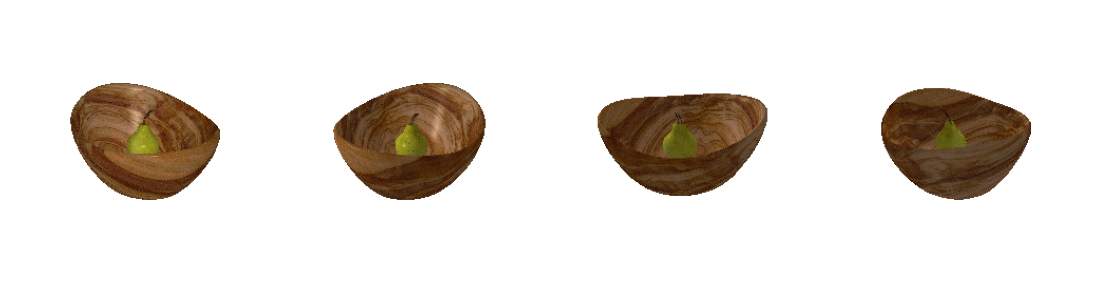

In [162]:
copy_obs = deepcopy(obs)
copy_obs[len(obs)] = [0.,0.,0.]

images, scene = get_scene(basic_multi_agent.input_objs, basic_multi_agent.best_obs)
cuda.empty_cache()
image_grid(images, rows=1, cols=4, rgb=True)

In [163]:
plot_batch_individually(scene)

In [7]:
import ray

ray.shutdown()
ray.init(ignore_reinit_error=True)

Usage stats collection is enabled by default for nightly wheels. To disable this, run the following command: `ray disable-usage-stats` before starting Ray. See https://docs.ray.io/en/master/cluster/usage-stats.html for more details.


2022-08-21 21:31:28,125	INFO worker.py:1421 -- Started a local Ray instance.


Python version:,3.7.13
Ray version:,3.0.0.dev0


In [94]:
from ray.tune.registry import register_env

def discrete_env_creator(args):
  return BasicMultiAgent(discrete=True)

# env = env_creator({})
register_env("discrete_clip_guided", discrete_env_creator)

# def continuous_env_creator(args):
#   return BasicMultiAgent(discrete=False)

# register_env("continuous_clip_guided", continuous_env_creator)

In [ ]:
import ray.rllib.algorithms.dqn as dqn

dqn.DEFAULT_CONFIG.copy()

In [96]:
from ray.rllib.algorithms.dqn import DQN

dqn_agent = DQN(
    env="discrete_clip_guided",
    config={
        'num_atoms': 10,
        'v_max': 5,
        'v_min': -5,
        "num_workers": 0,
        "num_gpus": 1,
        'hiddens': [512],
        "gamma": 0.9,
        "n_step": 256,
        # "framework": "torch",
        # "noisy": True,
        'grad_clip': 40.0,
        'min_train_timesteps_per_iteration': 1024,
        'metrics_num_episodes_for_smoothing': 3,
        'horizon': 256,
        'lr': 0.02,
        'train_batch_size': 256,
    },
)

2022-08-21 22:26:02,735	WARNING deprecation.py:48 -- DeprecationWarning: `ray.rllib.algorithms.dqn.dqn.DEFAULT_CONFIG` has been deprecated. Use `ray.rllib.algorithms.dqn.dqn.DQNConfig(...)` instead. This will raise an error in the future!
2022-08-21 22:26:02,737	WARNING deprecation.py:48 -- DeprecationWarning: `config['multiagent']['replay_mode']` has been deprecated. config['replay_buffer_config']['replay_mode'] This will raise an error in the future!


Usage stats collection is enabled by default for nightly wheels. To disable this, run the following command: `ray disable-usage-stats` before starting Ray. See https://docs.ray.io/en/master/cluster/usage-stats.html for more details.


2022-08-21 22:26:05,453	INFO worker.py:1421 -- Started a local Ray instance.
2022-08-21 22:26:13,508	WARNING multi_agent_env.py:239 -- observation_space_sample() has not been implemented
2022-08-21 22:26:13,510	WARNING multi_agent_env.py:151 -- observation_space_contains() has not been implemented
2022-08-21 22:26:13,511	WARNING multi_agent_env.py:151 -- observation_space_contains() has not been implemented
2022-08-21 22:26:13,513	WARNING multi_agent_env.py:151 -- observation_space_contains() has not been implemented
2022-08-21 22:26:13,514	WARNING multi_agent_env.py:207 -- action_space_sample() has not been implemented
2022-08-21 22:26:13,515	WARNING multi_agent_env.py:175 -- action_space_contains() has not been implemented
2022-08-21 22:26:13,658	WARNING multi_agent_env.py:151 -- observation_space_contains() has not been implemented


best


2022-08-21 22:26:16,190	INFO trainable.py:157 -- Trainable.setup took 13.457 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2022-08-21 22:26:16,630	WARNING util.py:65 -- Install gputil for GPU system monitoring.


In [97]:
result = dqn_agent.train()

best
best
best
best
best
best
best
best
best
best
best
best
best
best
best
best
best


2022-08-21 22:27:11,428	WARNING deprecation.py:48 -- DeprecationWarning: `ReplayBuffer.add_batch()` has been deprecated. Use `ReplayBuffer.add()` instead. This will raise an error in the future!
2022-08-21 22:27:11,832	WARNING multi_agent_prioritized_replay_buffer.py:216 -- Adding batches with column `weights` to this buffer while providing weights as a call argument to the add method results in the column being overwritten.


best
best
best
best
best
best
best
best
best
best
best
best
best
best
best


2022-08-21 22:27:47,752	WARNING deprecation.py:48 -- DeprecationWarning: `concat_samples` has been deprecated. Use `concat_samples() from rllib.policy.sample_batch` instead. This will raise an error in the future!


best
best
best
best
best
best
best
best
best
best
best
best
best
best
best
best


In [98]:
result

{'custom_metrics': {},
 'episode_media': {},
 'num_recreated_workers': 0,
 'info': {'learner': {'default_policy': {'learner_stats': {'cur_lr': 0.019999999552965164,
     'mean_td_error': 23.01516,
     'model': {}},
    'td_error': array([ 4.6336627 ,  3.1041741 , 25.452423  , 60.14514   , 14.900368  ,
            8.351682  , 25.907656  , 50.51499   , 33.406883  ,  2.6506858 ,
           22.193222  , 56.175076  ,  9.120267  , 25.933414  , 23.40437   ,
           16.785059  ,  7.4165707 , 20.825989  , 27.409412  ,  5.550921  ,
           25.452423  , 21.10723   , 43.506104  , 40.65833   ,  0.8477422 ,
            1.6201833 , 13.290145  , 34.755028  , 39.167202  , 14.864101  ,
           18.50602   , 15.011896  ,  4.590654  , 15.419146  , 22.49174   ,
            2.0997844 , 35.538925  ,  4.5535264 , 29.034222  ,  2.6966844 ,
           38.82283   , 29.69179   ,  3.034748  , 34.95611   ,  8.441537  ,
            0.8380975 , 36.50935   ,  4.037067  , 41.794796  , 26.823353  ,
           4

In [ ]:
# N_ITER = 3
# s = "{:3d} reward {:6.2f}/{:6.2f}/{:6.2f} episode_len_mean {:6.2f"

# for n in range(N_ITER):
#   result = dqn_agent.train()
#   sampler_results = result["sampler_results"]
#   print(s.format(
#       n+1,
#       sampler_results['episode_reward_mean'],
#       sampler_results['episode_reward_max'],
#       sampler_results['episode_reward_min'],
#       sampler_results["episode_len_mean"],
#   ))

In [99]:
from torch import cuda
cuda.empty_cache()

In [100]:
test_env = BasicMultiAgent()

cuda.empty_cache()

In [111]:
obs = test_env.reset()

for i in range(50):
  action = {}
  for agent_id, agent_obs in obs.items():
      action[agent_id] = dqn_agent.compute_single_action(agent_obs, policy_id='default_policy')
  obs, reward, done, info = test_env.step(action)
  if all(done):
    break

best
best
best
best


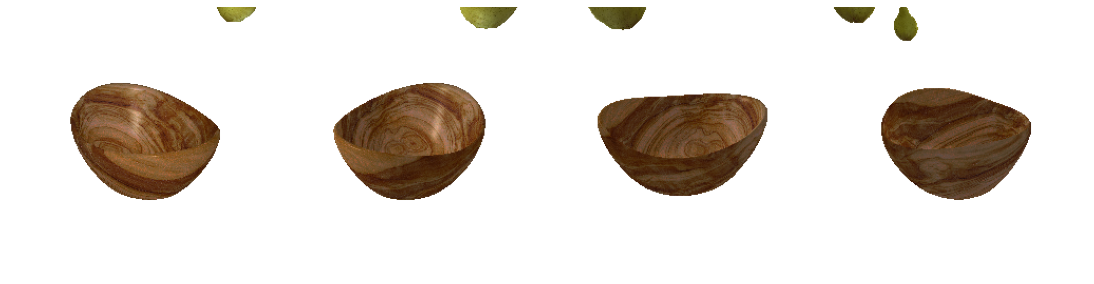

In [112]:
images, scene = get_scene(test_env.input_objs, test_env.best_obs)
image_grid(images, rows=1, cols=4, rgb=True)

In [ ]:
# plot_batch_individually(scene)

In [ ]:
from ray.rllib.algorithms import sac

sac.DEFAULT_CONFIG.copy()

In [10]:
sac_agent = sac.SAC(
  env="continuous_clip_guided",
  config={
    "num_workers": 0,
    "num_gpus": 1,
    "n_step": 256,
    'min_train_timesteps_per_iteration': 1024,
    'metrics_num_episodes_for_smoothing': 3,
    'horizon': 256,
    'train_batch_size': 256,
  },
)

2022-08-21 21:33:07,843	INFO tensorboardx.py:42 -- pip install "ray[tune]" to see TensorBoard files.
2022-08-21 21:33:08,375	WARNING unified.py:55 -- Could not instantiate TBXLogger: No module named 'tensorboardX'.
2022-08-21 21:33:08,378	INFO algorithm.py:2067 -- Your framework setting is 'tf', meaning you are using static-graph mode. Set framework='tf2' to enable eager execution with tf2.x. You may also then want to set eager_tracing=True in order to reach similar execution speed as with static-graph mode.
2022-08-21 21:33:08,380	WARNING deprecation.py:48 -- DeprecationWarning: `config['multiagent']['replay_mode']` has been deprecated. config['replay_buffer_config']['replay_mode'] This will raise an error in the future!
2022-08-21 21:33:08,386	INFO simple_q.py:303 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting `simple_optimizer=True` if this doesn't work for you.
2022-08-21 21:33:08,389	INFO algorithm.py:358 -- Current log

In [11]:
sac_result = sac_agent.train()

2022-08-21 21:34:14,961	WARNING deprecation.py:48 -- DeprecationWarning: `ReplayBuffer.add_batch()` has been deprecated. Use `ReplayBuffer.add()` instead. This will raise an error in the future!
2022-08-21 21:34:15,606	WARNING multi_agent_prioritized_replay_buffer.py:216 -- Adding batches with column `weights` to this buffer while providing weights as a call argument to the add method results in the column being overwritten.
2022-08-21 21:35:23,217	WARNING deprecation.py:48 -- DeprecationWarning: `concat_samples` has been deprecated. Use `concat_samples() from rllib.policy.sample_batch` instead. This will raise an error in the future!


In [12]:
sac_result

{'custom_metrics': {},
 'episode_media': {},
 'num_recreated_workers': 0,
 'info': {'learner': {'default_policy': {'learner_stats': {'mean_td_error': 1.7771938,
     'actor_loss': -2.3310025,
     'critic_loss': 0.30771875,
     'alpha_loss': -0.015120267,
     'alpha_value': 0.99700415,
     'target_entropy': -3.0,
     'mean_q': 0.3026259,
     'max_q': 0.49934822,
     'min_q': 0.104812235,
     'model': {}},
    'td_error': array([0.6275958 , 2.9477162 , 2.5080233 , 3.3059592 , 0.40027434,
           1.1635947 , 0.34307224, 3.631003  , 2.6873434 , 3.853664  ,
           0.64409673, 0.670926  , 0.7945437 , 2.9638903 , 1.8670201 ,
           3.2669518 , 1.1655744 , 1.2503767 , 0.14729369, 0.6502503 ,
           3.526596  , 2.632513  , 0.29695913, 2.5630498 , 2.3355486 ,
           1.4199748 , 2.666287  , 3.7061617 , 0.37150568, 2.2735977 ,
           0.8891837 , 1.357952  , 1.7724664 , 1.724906  , 0.55797005,
           3.3113766 , 3.296635  , 3.0307868 , 2.2182136 , 3.4647088 ,
    

In [14]:
from torch import cuda

cuda.empty_cache()

sac_env = BasicMultiAgent(discrete=False)


In [18]:
obs = sac_env.reset()

for i in range(200):
  action = {}
  for agent_id, agent_obs in obs.items():
      action[agent_id] = sac_agent.compute_single_action(agent_obs, policy_id='default_policy')
  obs, reward, done, info = sac_env.step(action)

  if all(done):
    break

In [19]:
sac_env.best_obs

{0: [3.396, -1.246, 5.077], 1: [5.859, -0.243, -1.915], 2: [-0.0, 0.0, 0.0]}

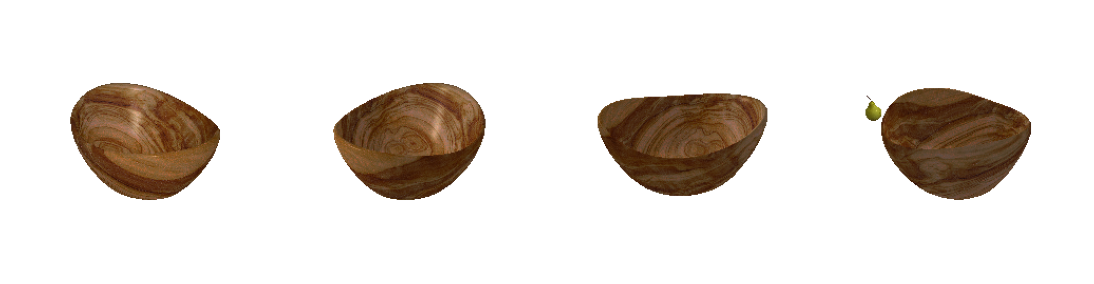

In [20]:
copy_obs = deepcopy(obs)
copy_obs[len(obs)] = [0.,0.,0.]
images, scene = get_scene(sac_env.input_objs, sac_env.best_obs)
image_grid(images, rows=1, cols=4, rgb=True)

In [ ]:
plot_batch_individually(scene)